In [99]:
import pandahouse 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хэши
from scipy import stats # Статистика
%matplotlib inline 

In [100]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20220720',
    'user':'student', 
    'password':'dpo_python_2020'
}

In [101]:
# Количество пользователей за выбранный период
q = """
SELECT uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-13' AND '2022-06-19'
"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,50149


In [102]:
# Разбиение пользователей по группам
q = """
SELECT distinct(user_id), exp_group
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN  '2022-06-13' AND '2022-06-19'
"""
users_df = pandahouse.read_clickhouse(q, connection=connection)
users_df. groupby('exp_group').user_id.nunique().reset_index()

,exp_group,user_id
0,0,9999
1,1,10079
2,2,9952
3,3,10049
4,4,10070


In [103]:
# Считаем ctr по каждому пользователю
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-13' AND '2022-06-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [104]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


In [105]:
# Увеличение масштаба графиков в seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})

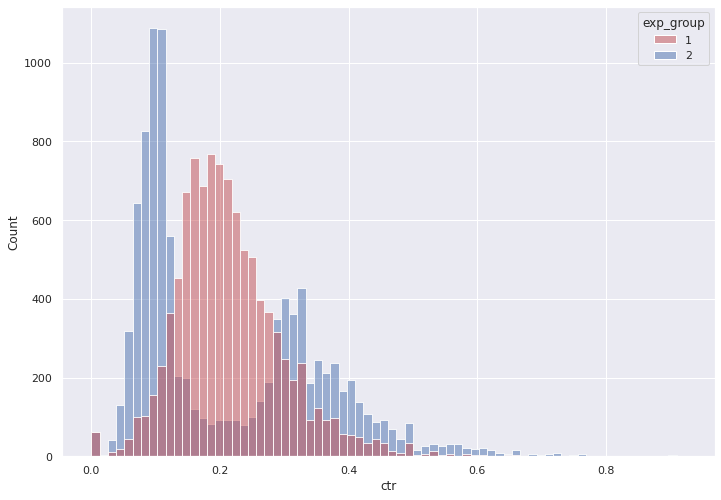

In [106]:
# Распределине на 2ух группах: 1-контрольная, 2 - использован один из новых алгоритмов рекомендации постов
groups = sns.histplot(data = df,
                      x = 'ctr',
                      hue = 'exp_group',
                      palette = ['r', 'b'],
                      alpha = 0.5,
                      kde = False)

In [107]:
# t - test. pvalue > 0.05, значит мы не можем отвергать H0. Возможно такие результаты связаны с почти одиноковыми средними значениями
stats.ttest_ind (df[df.exp_group == 1].ctr,
                 df[df.exp_group == 2].ctr,
                 equal_var = False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [108]:
df[df.exp_group == 1].ctr.mean(), df[df.exp_group == 2].ctr.mean()

(0.21560459841296287, 0.21441927347479375)

In [109]:
# Тест Манна-Уитни. pvalue очень маленькое, а значит тест видит значимые различия
stats.mannwhitneyu (df[df.exp_group == 1].ctr,
                 df[df.exp_group == 2].ctr)


MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

<h2>Сглаживание CTR</h2>

In [152]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha*global_ctr) / (user_views + alpha)
    return smothed_ctr

In [153]:
# Считаем ctr по каждому пользователю
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-13' AND '2022-06-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [154]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [155]:
# Увеличение масштаба графиков в seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

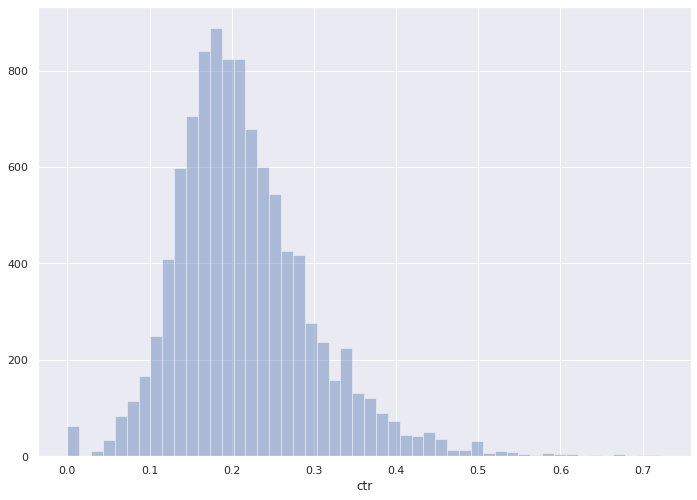

In [156]:
group1 = df[df.exp_group == 1].copy()
sns.distplot(group1.ctr,
             kde = False)

In [161]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 100), axis=1)

<AxesSubplot:xlabel='ctr'>

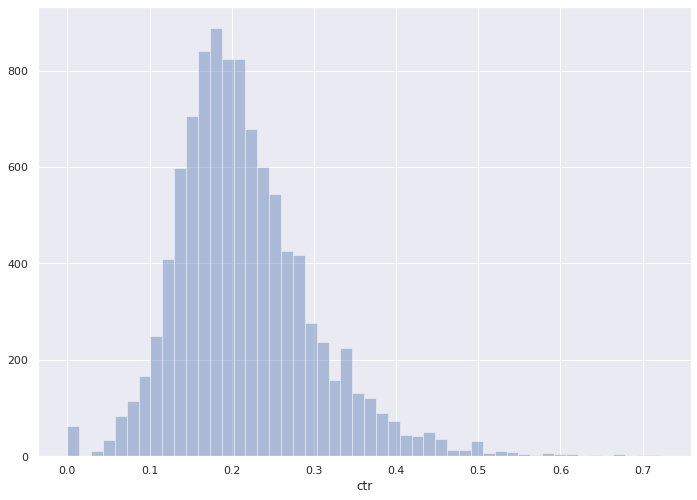

In [162]:
sns.distplot(group1.ctr,
             kde = False)

<AxesSubplot:xlabel='ctr'>

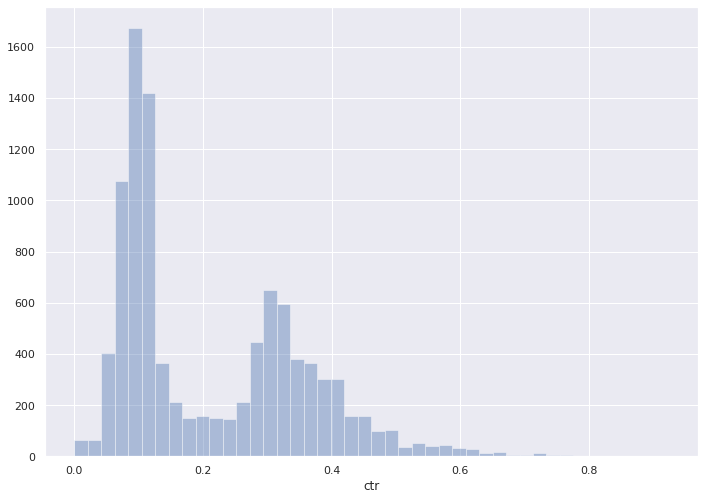

In [117]:
group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr,
             kde = False)

In [118]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

<AxesSubplot:xlabel='ctr'>

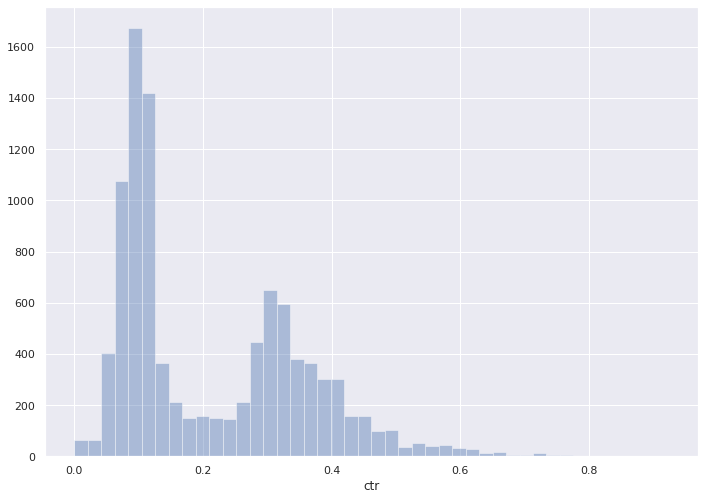

In [119]:
sns.distplot(group2.ctr,
             kde = False)

In [120]:
# t - test со сглаженым CTR. pvalue > 0.05, значит мы не можем отвергать H0.
stats.ttest_ind (group1.ctr,
                 group2.ctr,
                 equal_var = False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

<h2>Бутстреп</h2>

In [121]:
# Считаем ctr по каждому пользователю в группе 1
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-13' AND '2022-06-19'
    and exp_group=1
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [122]:
df_ctr_1 = df.ctr

In [123]:
df_ctr_1

0        0.200000
1        0.226950
2        0.246575
3        0.270492
4        0.218750
           ...   
10074    0.177778
10075    0.252747
10076    0.187500
10077    0.152027
10078    0.186441
Name: ctr, Length: 10079, dtype: float64

In [124]:
# Считаем ctr по каждому пользователю в группе 2
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-13' AND '2022-06-19'
    and exp_group=2
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [125]:
df_ctr_2 = df.ctr

In [126]:
df_ctr_2

0       0.104478
1       0.080460
2       0.108911
3       0.203125
4       0.444444
          ...   
9947    0.066667
9948    0.000000
9949    0.330709
9950    0.210526
9951    0.109756
Name: ctr, Length: 9952, dtype: float64

In [127]:
sample_ctr1 = df_ctr_1.sample(10000, replace = True).tolist()

In [128]:
sample_ctr2 = df_ctr_2.sample(10000, replace = True).tolist()

<AxesSubplot:>

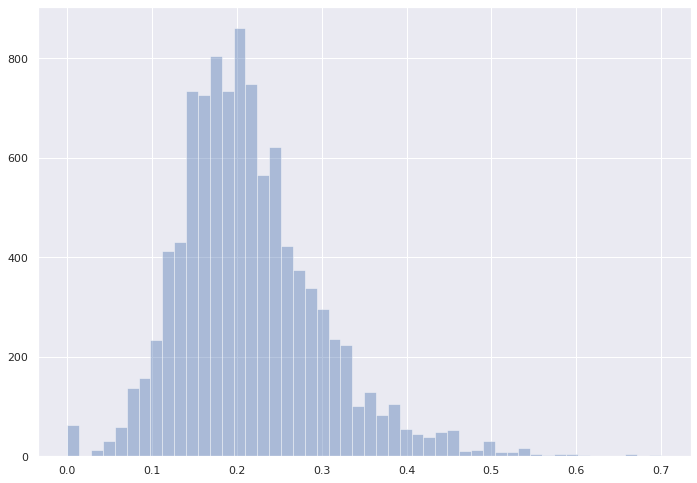

In [129]:
sns.distplot(sample_ctr1,
             kde = False)

<AxesSubplot:>

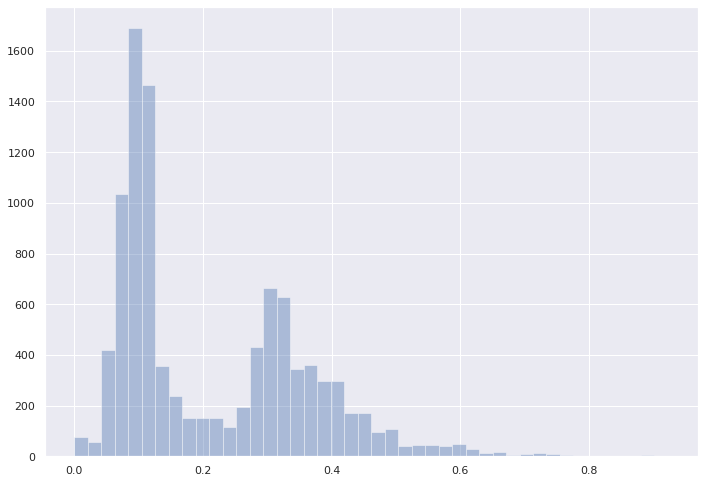

In [130]:
sns.distplot(sample_ctr2,
             kde = False)

In [131]:
# ttest 
stats.ttest_ind(sample_ctr1,
                sample_ctr2,
                equal_var = False)

Ttest_indResult(statistic=-0.017780307193686385, pvalue=0.9858143360505495)

<h2>Пуассоновский бутстреп для подсчета разницы в CTR</h2>

In [132]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap = 2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (2000, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (2000, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1,  globalCTR2

In [133]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-13' AND '2022-06-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)
likes1 = df[df.exp_group ==1].likes.to_numpy()
views1 = df[df.exp_group ==1].views.to_numpy()
likes2 = df[df.exp_group ==2].likes.to_numpy()
views2 = df[df.exp_group ==2].views.to_numpy()

In [134]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

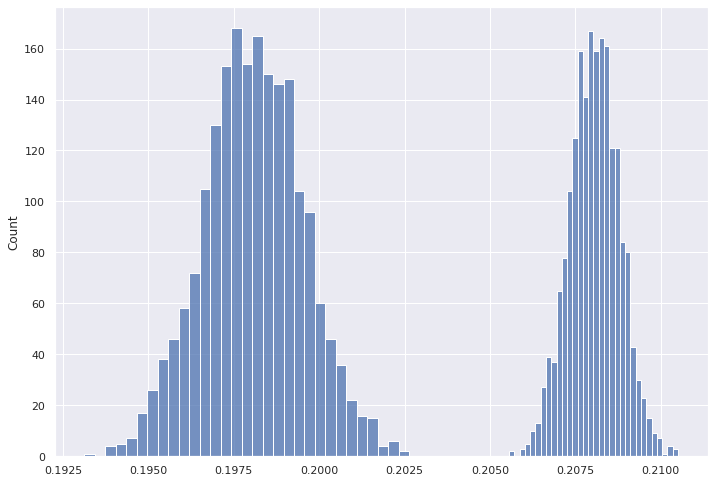

In [135]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

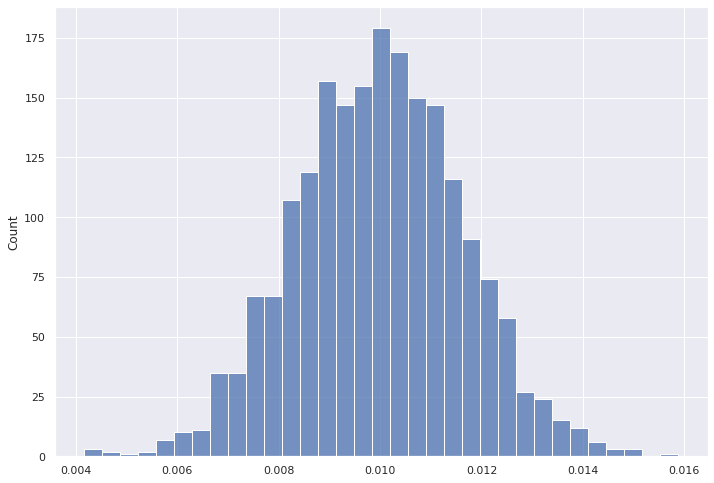

In [136]:
sns.histplot(ctr1 - ctr2)

In [137]:
# Группа 1 показала лучший результат по ctr, чем группа 2

<h2>Бакетное преобразование</h2>

In [140]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) BETWEEN '2022-06-13' AND '2022-06-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [141]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [ ]:
#Тест Манна-Уитни видит отличия 

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

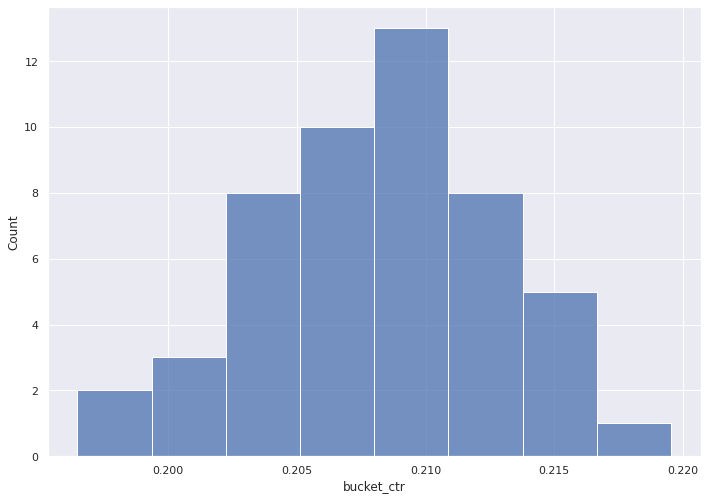

In [144]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

In [145]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [146]:
 #ttest видит отличия

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

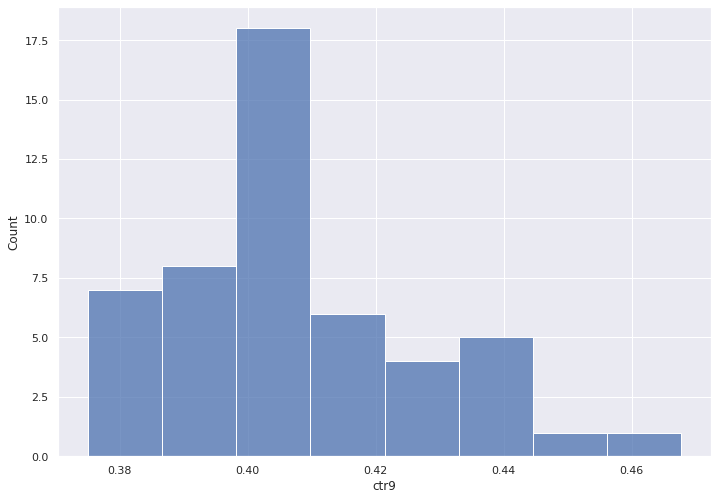

In [148]:
sns.histplot(df[df.exp_group == 2].ctr9)

In [149]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr9,
                   df[df.exp_group == 2].ctr9,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.344839189967265e-18)

In [151]:
#Тест Манна-Уитни видит отличия между 90%ых квантилей групп